# Clustering by Mini Batch K-Means

Here, we apply Mini Batch K-Means in attempt to segment data described by Recency, Frequency and Monetary Value of this group of customers. See [](../00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb) for how the data is prepared. 


References: 
- [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means)
- [Mini Batch K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

Notebooks Sequence:
- [/00-data/00-explore-and-prepare-data.ipynb](../00-data/00-explore-and-prepare-data.ipynb)
- [/00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb](../00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb)
- [This Notebook](../01-clustering/00-clustering-by-mini-batch-k-means.ipynb)
- [/02-interpretation/00-interprete.ipynb](../02-interpretation/00-interprete.ipynb)

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
import pickle

# Data
## Load Data

Cell below assumed that dataset is registered in AML Workspace.

In [2]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

# Get information about worksapce
workspace = Workspace.from_config()

# Get dataset registered in AML by name
dataset = Dataset.get_by_name(workspace, name='online-retail-frm-transformed')

# Convert Dataset to Pandas DataFrame
df_orig = dataset.to_pandas_dataframe()

In [3]:
# Make a copy
df = df_orig.copy()
df

Recency(Days)  Frequency  Monetary(£)
0         -0.179759   1.063773     1.550099
1          0.528757  -2.024859    -0.571557
2         -0.978211   0.760723     0.994984
3          0.482230  -0.020747     0.002961
4          0.805795  -0.723300    -0.096879
...             ...        ...          ...
3009      -0.814941  -0.553691    -0.412429
3010       0.497910  -1.014238    -0.951456
3011       1.461625  -0.932209    -0.919272
3012      -1.995571   2.681216     1.044905
3013      -0.102691  -1.787632    -1.692218

[3014 rows x 3 columns]

### Calculate Within Cluster Sum of Squared Errors (*WCSS*) aka Inertia
- The metric Within Cluster Sum of Squared Errors (*WCSS*) is the same as `km.inertia_`
- Inertia can be recognized as a measure of how internally coherent clusters are. 
- there are other metrics, e.g. `Silhouette Score` 
- By iterating from *k*=1 to *k*=10, *k* is the parameter required for k-means algorithm, we will be able to determine the most optimum value for *k*, i.e., finding the most optimum number of clusters in the dataset. 

In [4]:
def calculate_wcss(min_cluster, max_cluster, batch_size, data):
    """ Calculate Within Cluster Sum of Squared Errors (*WCSS*), i.e. km.inertia_ when iterate through min_cluster to max_cluster
    """
    wcss=[]
    for i in range(min_cluster, max_cluster):
        km = MiniBatchKMeans(n_clusters=i,
                             random_state=9,
                             batch_size=batch_size,
                             max_iter=100).fit(data)
        km.fit(data)
        wcss.append(km.inertia_)
    return wcss

In [5]:
# Set parameterss
min_cluster = 1
max_cluster = 11
batch_size = int(df.shape[0]*0.1)

# run calculate_wcss
wcss = calculate_wcss(min_cluster, max_cluster, batch_size, df)

### Elbow-Curve
Elbow-curve plots all the values obtained from `calculate_wcss`. 

The most optimum value for *k* is where the 'elbow joint' is, in this case, it is 4, after which the value of *wcss* decrease less than before. 

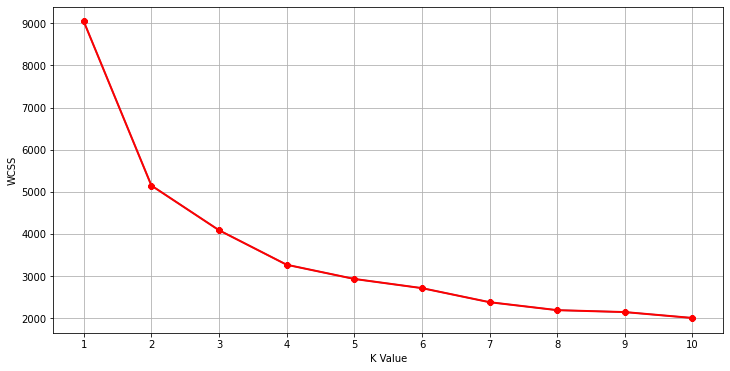

In [6]:
#The elbow curve
_ = plt.figure(figsize=(12,6))
_ = plt.plot(range(min_cluster, max_cluster), wcss)
_ = plt.plot(range(min_cluster, max_cluster),wcss, linewidth=2, color="red", marker ="8")
_ = plt.xlabel("K Value")
_ = plt.xticks(np.arange(1,11,1))
_ = plt.ylabel("WCSS")
_ = plt.grid(True)
_ = plt.show()

### Set *k* to 4

In [7]:
# Assuming 4 clusters
n_clusters = 4

# Fit data
km = MiniBatchKMeans(n_clusters=n_clusters,
                     random_state=9,
                     batch_size=batch_size,
                     max_iter=100).fit(df)

# Fitting the input data
km.fit(df)

# save the model locally
if False: # Set 'True' to run the codes below
#if True:
    model_filepath = f'../../.aml/models/mini-batch-k-means-customer-segmentation.pkl'
    pickle.dump(km, open(model_filepath, "wb"))

# Predicting the labels of the input data
y = km.predict(df)

# Make a copy
df_clusters = df.copy()

# Add the labels to a column named label
df_clusters["label"] = y

# Display predictions
df_clusters

MiniBatchKMeans(batch_size=301, n_clusters=4, random_state=9)

Recency(Days)  Frequency  Monetary(£)  label
0         -0.179759   1.063773     1.550099      2
1          0.528757  -2.024859    -0.571557      1
2         -0.978211   0.760723     0.994984      2
3          0.482230  -0.020747     0.002961      3
4          0.805795  -0.723300    -0.096879      3
...             ...        ...          ...    ...
3009      -0.814941  -0.553691    -0.412429      0
3010       0.497910  -1.014238    -0.951456      1
3011       1.461625  -0.932209    -0.919272      1
3012      -1.995571   2.681216     1.044905      2
3013      -0.102691  -1.787632    -1.692218      1

[3014 rows x 4 columns]

### Register the Model

In [8]:
#if True:
if False: # Set 'True' to run the codes below
    from azure.ai.ml import MLClient
    from azure.ai.ml.entities import Model
    from azure.identity import DefaultAzureCredential

    # get a handle to the workspace
    ml_client = MLClient(credential=DefaultAzureCredential(), 
                         subscription_id=workspace.subscription_id, 
                         resource_group_name=workspace.resource_group, 
                         workspace_name=workspace.name)
    ml_client

    model_filepath = f'../../.aml/models/mini-batch-k-means-customer-segmentation.pkl'

    file_model = Model(
        path = model_filepath,
        name = "mini-batch-k-means-customer-segmentation",
        description = 'mini-batch-k-means-customer-segmentation | scikit-learn==1.1.1',
        auto_increment_version = True,)
    
    ml_client.models.create_or_update(file_model)

## Visualise

### 1. t-SNE
[t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a convenient way to visualise high dimensional data, by giving each data point a location in a 2D or 3D map. 

While the data here is only 3 dimenstion, this technique is included here for reference. 

Reference:
- [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
- [User Guide](https://scikit-learn.org/stable/modules/manifold.html#t-sne)

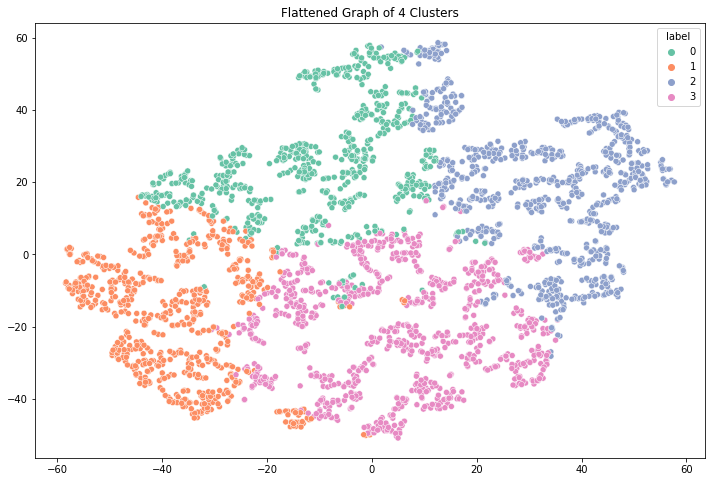

In [9]:
# Make a copy
df_clusters_tsne = df.copy()

# Apply TSNE to data
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random').fit_transform(df_clusters_tsne)

# Plot t-SNE
_ = plt.figure(figsize=(12,8))
_ = plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
_ = sns.scatterplot(x=X_embedded[:,0], 
                    y=X_embedded[:,1], 
                    hue=df_clusters["label"], 
                    palette="Set2")
plt.show()

From the figure above, the 4 predicted clusters are distintive in the t-sne plot. 

### 2. 3D Scatter Plot

In Jupyter Notebook, the 3D graph below is interactive. 

In [10]:
# 3D scatter plot
fig = px.scatter_3d(df_clusters, 
                    x='Monetary(£)', y='Frequency', z='Recency(Days)',  		
                    color='label',
                    width=1200, height=800) # figure size
fig.show()

The 3D plot above shows clear distinction of the 4 clusters.

### 3. Pair Plot
The pair plot below shows the distribution of each factor, i.e. Recency, Frequency and Monetary, at the same time, also shows the correlation among them, with colour to distinguish the 4 different clusters. 

<Figure size 1080x648 with 0 Axes>

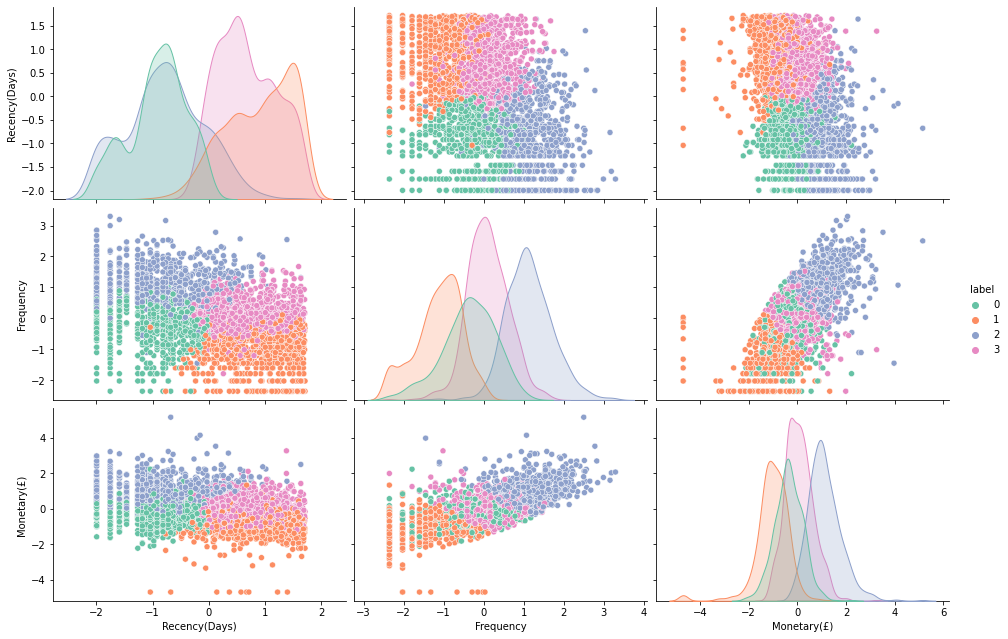

In [11]:
_ = plt.figure(figsize=(15,9)) 
_ = sns.pairplot(data=df_clusters, 
                 hue='label', 
                 palette='Set2', 
                 height=3, 
                 aspect=1.5)
_ = plt.show()

### Possible Interpretation
See [/02-interpretation/00-interprete.ipynb](../02-interpretation/00-interprete.ipynb) for example interpretation of these clusters.